In [28]:
from collections import Counter

import pandas as pd
import regex as re
import numpy as np
from itertools import chain
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import cross_val_score
import pickle
from sklearn.metrics import fbeta_score

In [29]:
train_df = pd.read_csv('data/train_v2.csv')
test_df = pd.read_csv('data/test_v2.csv')

print('train_df size: {}, test_df size: {}'.format(train_df.shape, test_df.shape))

train_df size: (6027, 7), test_df size: (3826, 6)


In [30]:
# In this part, we find most frequent unigram
data = train_df[(train_df.category == 2)]['title']
#df = train_df[(train_df.category > 1) & (train_df.category != 3)]

cv = CountVectorizer()
data = cv.fit_transform(data)

tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(data)
word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))
sorted_word2 = sorted(word2tfidf.items(), key=lambda kv: kv[1], reverse=False)

def find_frequent_unigram(cat):
    data = train_df[(train_df.category == cat)]['title']
    cv = CountVectorizer()
    data = cv.fit_transform(data)
    
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(data)
    word2tfidf = dict(zip(cv.get_feature_names(), tfidf_transformer.idf_))
    sorted_word2 = sorted(word2tfidf.items(), key=lambda kv: kv[1], reverse=False)
    fp = 'data/cat-{}-frequent.txt'.format(cat)
    with open(fp, 'w+') as wf:
        wf.write('word, idf\n')
        for item in sorted_word2:
            wf.write('{}, {}\n'.format(item[0], item[1]))
    print('done')
            

find_frequent_unigram(0)
find_frequent_unigram(1)
find_frequent_unigram(2)
find_frequent_unigram(3)
find_frequent_unigram(4)


# 有一些stopwords 不能去掉，例如 down

done
done
done
done
done


In [31]:
cat_2_word = pd.read_csv('data/cat-2-frequent.txt')['word'].values
cat_4_word = pd.read_csv('data/cat-4-frequent.txt')['word'].values
print(cat_2_word[: 10], cat_4_word[: 10])
intersection_2_4 = [item for item in cat_2_word if item in cat_4_word]
residual_2_4 = [item for item in cat_2_word if item not in cat_4_word]
print('cat-2: {}, cat_4: {}, intersection: {}'.format(len(cat_2_word), len(cat_4_word), len(intersection_2_4)))

def calculate_intersection():
    for i in range(4):
        cat = pd.read_csv('data/cat-{}-frequent.txt'.format(i))['word'].values
        cat_4 = pd.read_csv('data/cat-{}-frequent.txt'.format(4))['word'].values
        intersection = [item for item in cat if item in cat_4]
        print('cat{} unique word: {}, cat_4 unique word: {}, intersection word: {}, intersection percentage: {}'.format(i, len(cat), len(cat_4), len(intersection), len(intersection) / float(len(cat))))
        
#calculate_intersection()
#print(intersection_2_4[: 200])
#print('---')
#print(residual_2_4[: 200])


['to' 'in' 'for' 'on' 'us' 'of' 'video' 'china' 'the' 'billion'] ['to' 'in' 'of' 'for' 'on' 'the' 'us' 'china' 'missing' 'plane']
cat-2: 2605, cat_4: 3828, intersection: 1731


In [32]:
from sklearn.feature_extraction import stop_words
print(len(stop_words.ENGLISH_STOP_WORDS))
my_stop_word = ['forty', 'much', 'whereafter', 'towards', 'our', 'during', 'done', 'one', 'please', 'whom', 'whereas', 'hers', 'thick', 'him', 'never', 'upon', 'are', 'whose', 'ten', 'except', 'than', 'those', 'whereupon', 'already', 'across', 're', 'somewhere', 'became', 'fire', 'six', 'without', 'although', 'third', 'eleven', 'amoungst', 'becomes', 'below', 'all', 'any', 'nothing', 'almost', 'how', 'in', 'he', 'over', 'seem', 'about', 'see', 'around', 'often', 'few', 'therefore', 'what', 'yourselves', 'both', 'keep', 'ours', 'always', 'once', 'others', 'seeming', 'none', 'perhaps', 'its', 'whether', 'whoever', 'be', 'etc', 'call', 'indeed', 'latter', 'further', 'last', 'three', 'eg', 'interest', 'other', 'but', 'your', 'here', 'per', 'wherein', 'against', 'sometime', 'within', 'name', 'former', 'may', 'when', 'will', 'whither', 'cry', 'beforehand', 'themselves', 'to', 'whereby', 'from', 'can', 'put', 'ie', 'bottom', 'which', 'have', 'not', 'seemed', 'until', 'somehow', 'was', 'cant', 'nobody', 'several', 'side', 'thru', 'now', 'four', 'there', 'neither', 'some', 'enough', 'otherwise', 'yet', 'into', 'still', 'anyone', 'made', 'via', 'everyone', 'give', 'take', 'thereby', 'amongst', 'thereafter', 'becoming', 'elsewhere', 'noone', 'no', 'onto', 'am', 'because', 'find', 'meanwhile', 'my', 'it', 'since', 'this', 'toward', 'anywhere', 'very', 'ever', 'another', 'formerly', 'her', 'hereby', 'me', 'an', 'himself', 'such', 'hereafter', 'might', 'afterwards', 'mine', 'nine', 'the', 'five', 'therein', 'where', 'why', 'anything', 'someone', 'that', 'after', 'fifteen', 'everywhere', 'herself', 'sometimes', 'nevertheless', 'mostly', 'show', 'a', 'part', 'before', 'together', 'either', 'of', 'whatever', 'de', 'eight', 'own', 'beyond', 'detail', 'even', 'were', 'cannot', 'fill', 'moreover', 'under', 'if', 'con', 'them', 'empty', 'get', 'system', 'nor', 'his', 'front', 'describe', 'must', 'then', 'between', 'been', 'bill', 'you', 'had', 'well', 'ourselves', 'alone', 'twelve', 'too', 'each', 'else', 'hundred', 'among', 'also', 'only', 'whole', 'less', 'hasnt', 'being', 'off', 'first', 'these', 'could', 'ltd', 'back', 'nowhere', 'with', 'everything', 'co', 'seems', 'sincere', 'myself', 'beside', 'go', 'every', 'rather', 'two', 'on', 'move', 'i', 'hence', 'who', 'due', 'amount', 'full', 'again', 'hereupon', 'fifty', 'whence', 'un', 'besides', 'latterly', 'mill', 'same', 'through', 'would', 'serious', 'sixty', 'top', 'most', 'we', 'anyway', 'couldnt', 'while', 'yourself', 'thus', 'become', 'their', 'thereupon', 'more', 'namely', 'above', 'wherever', 'found', 'itself', 'thin', 'thence', 'has', 'is', 'yours', 'by', 'for', 'though', 'along', 'out', 'she', 'next', 'twenty', 'however', 'something', 'herein', 'inc', 'at', 'do', 'throughout', 'as', 'anyhow', 'and', 'they', 'whenever', 'least', 'behind', 'or', 'should', 'so', 'many']
print(len(my_stop_word))

318
315


0


/diskA/yisong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/diskA/yisong/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:823: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


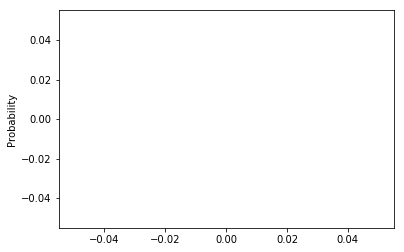

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.stem.porter import *
stemmer = PorterStemmer()

#print(stemmer.stem('obamacare')) 得到 obamacar

# 在这里，把 obamacar 当作 stopword!

def get_new_stopwords():
    manual_stopwords = ['obamacar', 'say', 'said', 'monday', 'tuesday',
                       'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
                       'january', 'february', 'march', 'april', 'may', 'june',
                       'july', 'april', 'may', 'june', 'july', 'august', 'september',
                       'octerber', 'november', 'december']
    words = [stemmer.stem(word) for word in manual_stopwords]
    return words

manual_stopwords = get_new_stopwords()

def my_tokenizer(s):
    words = re.findall(r'[A-Za-z]+', s)
    words = [word.lower() for word in words]
    words = [stemmer.stem(word) for word in words]
    words = [word for word in words if (len(word) > 1 and word not in manual_stopwords)]
    return words


def show_tokenizer():
    tag = []
    for i in range(train_df.shape[0]):
        #if i % 100 != 1:
        #    continue
        title = train_df.iloc[i]['title']
        title_ = my_tokenizer(title)
        #print('title: {}\n{}'.format(train_df.iloc[i]['title'], title_))
        if 'obamacar' in title_:
            #print('tag: {}\n{}'.format(train_df.iloc[i]['category'], title_))
            tag.append(train_df.iloc[i]['category'])
    print(len(tag))
    plt.hist(tag, normed=True, bins=5)
    plt.ylabel('Probability')
    plt.show()


show_tokenizer()

In [34]:
def find_obamacare():
    index = []
    for i in range(test_df.shape[0]):
        title = train_df.iloc[i]['title']
        title_ = my_tokenizer(title)
        if 'obamacar' in title_:
            index.append(i)
    return index


obama_index = find_obamacare()

In [35]:
X = train_df['title']
y = train_df['category']

#X = train_df[((train_df.category == 2) | (train_df.category == 4))]['title']
#y = train_df[((train_df.category == 2) | (train_df.category == 4))]['category']
print(X.shape, y.shape)

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), tokenizer=my_tokenizer, stop_words='english')),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42)),])

#('clf-lr', LogisticRegression(C=1, fit_intercept=True, penalty='l2', tol=0.01))
#('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

text_clf_svm = text_clf_svm.fit(X_train.values.astype('U'), y_train.values)
print('fit done')

result = text_clf_svm.predict(X_test)
print('f1 score is:{}'.format(fbeta_score(y_test, result, average='micro', beta=1)))

scores = cross_val_score(text_clf_svm, X.values.astype('U'), y, cv=5, scoring='f1_micro')
print(scores, np.mean(scores))

(6027,) (6027,)


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


fit done
f1 score is:0.681592039800995


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[0.50413907 0.51409619 0.56716418 0.7358804  0.90024938] 0.6443058425839673


/diskA/yisong/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


In [36]:
train_raw = pickle.load(open('data/train_v2.pk', 'rb'))
test_raw = pickle.load(open('data/test_v2.pk', 'rb'))

train_feature = text_clf_svm.steps[0][1].get_feature_names()
print(len(train_feature))

custom_tokens = dict()

for i in range(train_df.shape[0]):
    #if i % 50 != 0:
    #    continue
    title_ = my_tokenizer(train_df.iloc[i]['title'])
    if train_raw[i] is None or len(train_raw[i]) < 500:
        custom_tokens[''.join(('train', str(i)))] = title_
        continue
    extend = my_tokenizer(train_raw[i])[: 100000]
    custom_tokens[''.join(('train-', str(i)))] = title_ + extend

for i in range(test_df.shape[0]):
    #if i % 50 != 0:
    #    continue
    title_ = my_tokenizer(test_df.iloc[i]['title'])
    if test_raw[i] is None or len(test_raw[i]) < 500:
        custom_tokens[''.join(('test', str(i)))] = title_
        continue
    extend = my_tokenizer(test_raw[i])[: 100000]
    #new_word = [word for word in extend if (word in train_feature and word not in title_)]
    #new_word = list(set(new_word))
    #print(i, len(new_word), new_word)
    #print(title_)
    custom_tokens[''.join(('test', str(i)))] = title_ + extend

print('finished')


16151
finished


In [40]:
train_key = [k for k in custom_tokens.keys() if k[: 2] == 'tr']
test_key = [k for k in custom_tokens.keys() if k[: 2] == 'te']
print(len(train_key), len(test_key))

6027 3826


fit done


/diskA/yisong/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


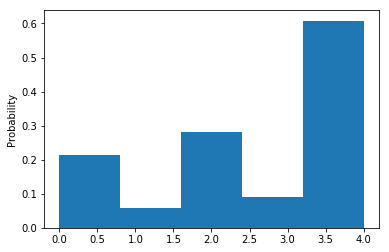

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline
# for submit
X_test = test_df['title']

text_clf_svm = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2), tokenizer=lambda key: custom_tokens[key], stop_words=my_stop_word)),
                      ('tfidf', TfidfTransformer(use_idf=True)),
                      ('NB', MultinomialNB(alpha=0.1, fit_prior=True))])

#('NB', MultinomialNB(alpha=0.1, fit_prior=True))
#('clf-lr', LogisticRegression(C=1, fit_intercept=True, penalty='l2', tol=0.01))
#('clf-svm', SGDClassifier(alpha=0.001, loss='hinge', penalty='l2', warm_start=True, n_iter=6, random_state=42))
text_clf_svm = text_clf_svm.fit(train_key, y.values)
print('fit done')

result = text_clf_svm.predict(test_key)

write_file = open('improvement-add-all-nb.txt', 'w+')
write_file.write('article_id,category\n')
i = 1
for item in result:
    write_file.write('{},{}\n'.format(i, item))
    i += 1
write_file.close()

plt.hist(result, normed=True, bins=5)
plt.ylabel('Probability')
plt.show()


In [43]:
re0 = pd.read_csv('improvement-add-all.txt')['category'].values
re1 = pd.read_csv('improvement-add-1000.txt')['category'].values

difference = 0
for i in range(0, len(re0)):
    if re0[i] != re1[i]:
        difference += 1
print(difference)

3


In [62]:
re_all_nb = pd.read_csv('improvement-add-all-nb.txt')['category'].values
re_all_lr = pd.read_csv('improvement-add-all-lr.txt')['category'].values
re_all_svm = pd.read_csv('improvement-add-all-svm.txt')['category'].values

#improvement-add-all-svm.txt 有0.87140

c = 0
for i in range(len(re_svm)):
    if (re_all_lr[i] == re_all_svm[i] and re_all_nb[i] == re_all_svm[i]):
        c += 1
print('total disagree: {}'.format(len(re_all_nb) - c))

svm_lr_dis = len([item for i, item in enumerate(re_all_svm) if item != re_all_lr[i]])
svm_nb_dis = len([item for i, item in enumerate(re_all_svm) if item != re_all_nb[i]])
lr_nb_dis = len([item for i, item in enumerate(re_all_lr) if item != re_all_nb[i]])
print('svm ≠ lr: {}, svm ≠ nb: {}, lr ≠ nb: {}'.format(svm_lr_dis, svm_nb_dis, lr_nb_dis))

nblr_vs_svm = len([item for i, item in enumerate(re_all_svm) if (item != re_all_lr[i] and item != re_all_nb[i])
                  and (re_all_lr[i] == re_all_nb[i])])
print('nb and lr is same, overthrow smv: {}'.format(nblr_vs_svm))

total disagree: 400
svm ≠ lr: 148, svm ≠ nb: 366, lr ≠ nb: 293
nb and lr is same, overthrow smv: 107
